In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import os

# Obtain current working directory
os.chdir('..')

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from settings import settings

from functions.img_generator import  create_img_generator
from functions.auxiliar_functions import plot_imgs_from_generator, plot_samples

2023-12-12 20:06:10.273104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 20:06:10.273177: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 20:06:10.273249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Check if GPU is running
print(len(tf.config.list_physical_devices('GPU')) > 0)

# See GPU devices in use
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set memory growth to True. This will allow to allocate memory as needed
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Get train and test paths
train_path, test_path = settings.train, settings.test

# Load train and test data
train = pd.read_csv(settings.data_train, header=None)
test = pd.read_csv(settings.data_test, header=None)
train.shape, test.shape

((8144, 6), (8041, 6))

In [7]:
# Load model names
model_names = pd.read_csv(settings.car_model, header=None)[0].tolist()

# Correct model names for them to be turned into folder name
model_names = [name.replace('/', '-') for name in model_names]

print(len(model_names), '\n', model_names[:5])

196 
 ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [8]:
# Change Column Names
train.columns = test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']
test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']

# For each item in df, find the corresponding model name
train['model'] = train.label.apply(lambda x: model_names[x-1])
test['model'] = test.label.apply(lambda x: model_names[x-1])

# Correct model names for them to be turned into folder name
train['model'] = train.model.apply(lambda x: x.replace('/', '-'))
test['model'] = test.model.apply(lambda x: x.replace('/', '-'))

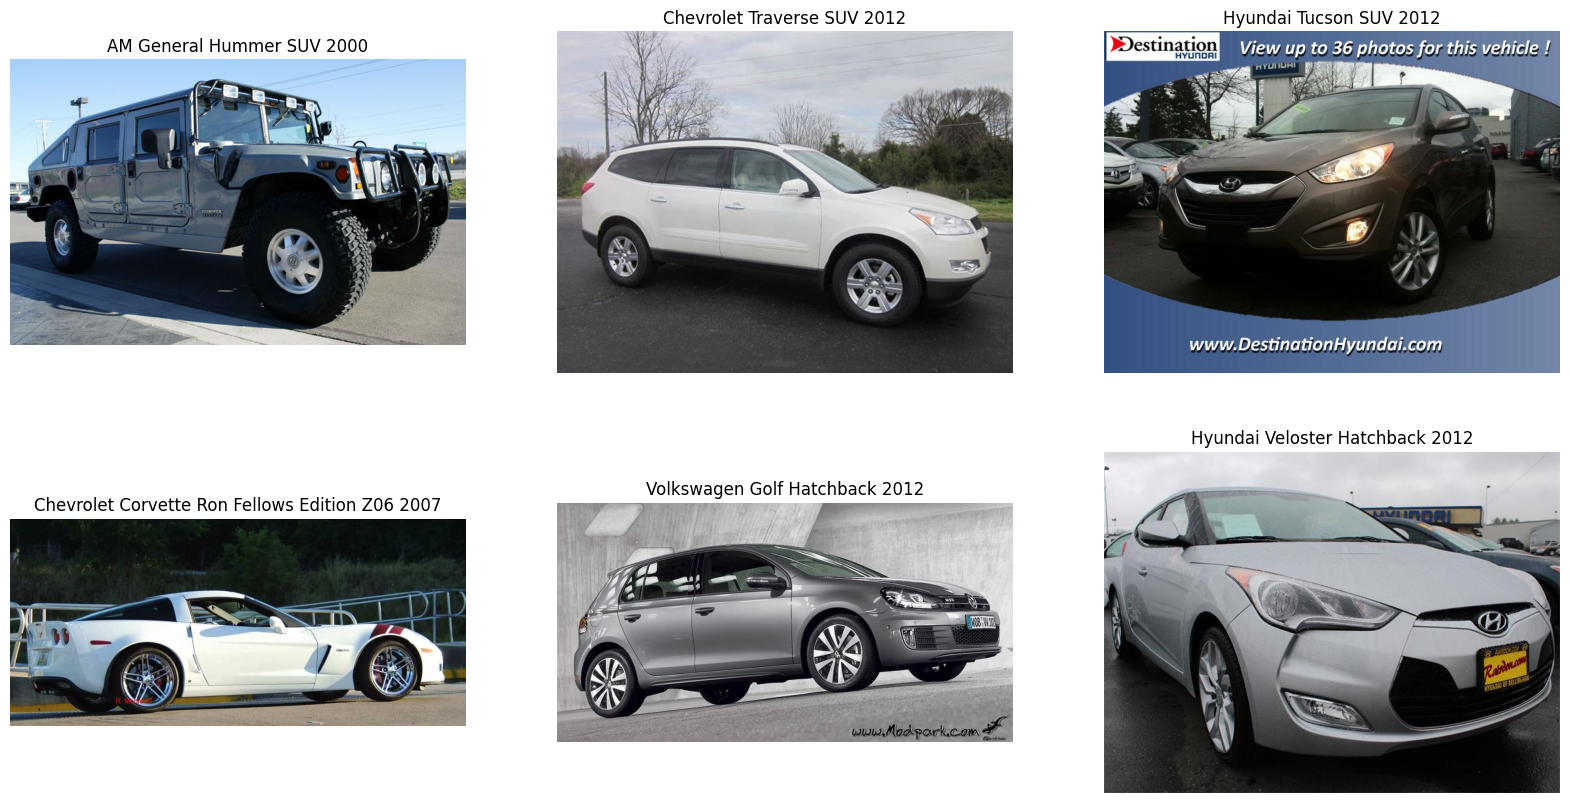

In [9]:
plot_samples(train)

In [10]:
num_classes = len(model_names)

# Target Sizes
TARGET_SIZE_224 = (224, 224)
TARGET_SIZE_64 = (64, 64)
TARGET_SIZE_32 = (32, 32)

# Batch Sizes
BATCH_SIZE_128 = 128
BATCH_SIZE_64 = 64
BATCH_SIZE_32 = 32
BATCH_SIZE_16 = 16
BATCH_SIZE_8 = 8


# Create Image Generators with different target sizes and batch sizes
train_gen_224, test_gen_224, val_gen_224 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_224)

train_gen_64, test_gen_64, val_gen_64 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_64)

train_gen_32, test_gen_32, val_gen_32 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_32)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.



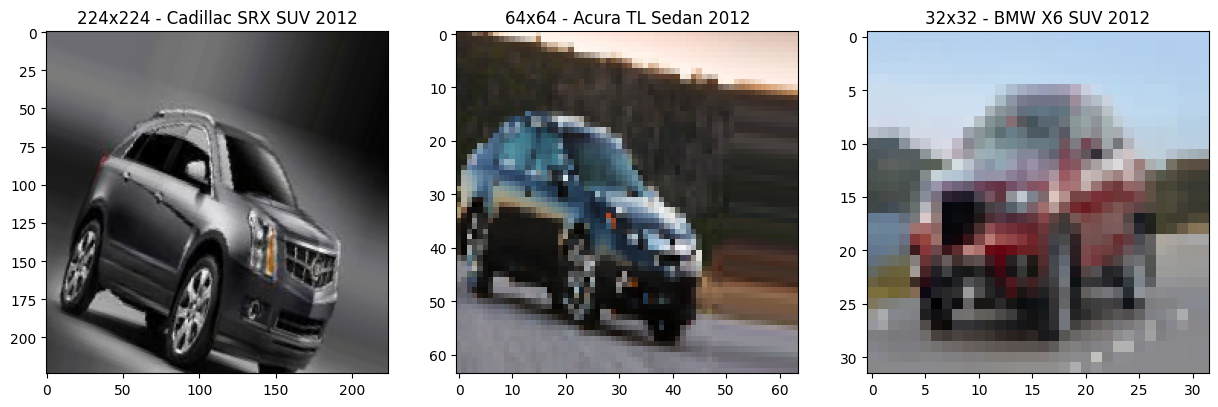

In [11]:
train_generators = {'224': train_gen_224,
                    '64': train_gen_64,
                    '32': train_gen_32}

plot_imgs_from_generator(train_generators, ncols=len(train_generators))

In [12]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

El transfer learning sobre ResNet50 es una técnica que consiste en usar un modelo preentrenado en el conjunto de datos ImageNet y reutilizarlo para clasificar otras imágenes de diferentes categorías. El transfer learning permite aprovechar el conocimiento que el modelo ha aprendido de las características visuales generales y adaptarlo a un nuevo dominio. Hay dos formas principales de hacer transfer learning sobre ResNet50:

- **Extracción de características**: Esta forma consiste en usar la parte convolucional de ResNet50 como un extractor de características fijo y añadir una nueva capa de clasificación al final. La nueva capa se entrena con los datos del nuevo dominio, mientras que los pesos de la parte convolucional se mantienen congelados. Esta forma es útil cuando se tiene un conjunto de datos pequeño o muy similar al de ImageNet.

- **Ajuste fino**: Esta forma consiste en usar la parte convolucional de ResNet50 como una base inicial y modificar algunos de sus pesos durante el entrenamiento. La nueva capa de clasificación se añade al final y se entrena con los datos del nuevo dominio, junto con algunos de los pesos de la parte convolucional. Esta forma es útil cuando se tiene un conjunto de datos grande o muy diferente al de ImageNet.

In [13]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=TARGET_SIZE_224 + (3,))

# Freeze base model layers
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

``BatchNormalization`` es una técnica que permite normalizar las activaciones de las capas intermedias de una red neuronal, lo que mejora la estabilidad y el rendimiento del entrenamiento1. ``BatchNormalization`` también puede actuar como un regularizador, reduciendo la necesidad de usar otras técnicas como el dropout2.

En el caso del Standford Cars Dataset, que contiene imágenes de 196 clases de coches con diferencias muy finas entre ellas3, ``BatchNormalization`` puede ser efectivo para evitar el sobreajuste y mejorar la generalización de la red. Algunos ejemplos de redes que usan ``BatchNormalization`` para clasificar este conjunto de datos son VGG194, ResNet505 y EfficientNet6. Estas redes usan ``BatchNormalization`` como True para adaptar las capas pre-entrenadas en ImageNet al nuevo conjunto de datos, evitando el problema de usar estadísticas diferentes en el entrenamiento y la inferencia4.

El callback ``ModelCheckpoint`` en Keras se utiliza para guardar el modelo durante el entrenamiento en función de ciertos criterios. 

`resnet50_stanford_cars.keras`: Especifica el nombre del archivo en el que se guardará el modelo. En este caso, se está utilizando la extensión .keras en lugar de la extensión .h5 como recomienda el mensaje de advertencia.

``save_best_only=True``: Esto asegura que solo se guarde el modelo si la métrica monitorizada mejora con respecto al mejor modelo existente. Si ``save_best_only`` está configurado en ``True``, se sobrescribirá el archivo cada vez que se encuentre un modelo con un rendimiento mejor que el modelo anterior.

``monitor='val_loss'``: Se monitorea la métrica de pérdida en el conjunto de validación (*val_loss*). El modelo se guardará si esta métrica mejora. Puedes elegir otras métricas como '*val_accuracy*' si estás más interesado en la precisión en lugar de la pérdida.

``mode='min'``: Indica que se debe considerar una mejora cuando la métrica monitorizada (*val_loss*) disminuye. Podría ser 'max' si estás monitoreando una métrica donde valores más altos son mejores, como la precisión.

``verbose=1``: Esto simplemente imprime mensajes informativos al guardar el modelo, lo cual puede ser útil para dar retroalimentación durante el entrenamiento. Un valor de 1 indica que se imprimirán mensajes.

El callback ``EarlyStopping`` en Keras es una herramienta útil para evitar el sobreajuste durante el entrenamiento al detener automáticamente el entrenamiento del modelo cuando ciertas condiciones no mejoran. Aquí hay una explicación de los argumentos más comunes utilizados en EarlyStopping:

- ``monitor``: Especifica la métrica que se debe monitorear para la detección de la parada temprana. Puedes elegir entre métricas como 'val_loss', 'val_accuracy', 'loss', 'accuracy', etc. Por ejemplo, si estás más interesado en la precisión en el conjunto de validación, puedes usar 'val_accuracy'.

- ``patience``: Representa el número de épocas sin mejora después de las cuales el entrenamiento se detendrá. Si, por ejemplo, estableces patience=6, el entrenamiento se detendrá después de 3 épocas consecutivas sin mejoras en la métrica monitoreada.

- ``restore_best_weights``: Si está configurado como True, restaurará los pesos del modelo a los mejores alcanzados durante el entrenamiento. Esto es útil para asegurarse de que el modelo que obtienes después del entrenamiento sea el mejor en términos de la métrica monitorizada.

- ``mode``: Puede ser 'min', 'max' o 'auto'. Define si se espera que la métrica monitorizada sea minimizada ('min') o maximizada ('max'). El modo 'auto' selecciona automáticamente el modo según la métrica monitorizada.

In [13]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Create callbacks 
checkpoint = ModelCheckpoint('resnet50_1.ckpt', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)

model.fit(train_gen_224, validation_data=val_gen_224,
          epochs=100, batch_size=128, callbacks=[checkpoint, early_stopping])

# Evaluate model
loss, acc = model.evaluate(test_gen_224, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 5.2782 - accuracy: 0.0077
Epoch 1: val_loss improved from inf to 5.27709, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 182s 765ms/step - loss: 5.2782 - accuracy: 0.0077 - val_loss: 5.2771 - val_accuracy: 0.0084
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 5.1901 - accuracy: 0.0086
Epoch 2: val_loss did not improve from 5.27709
207/207 [==============================] - 152s 732ms/step - loss: 5.1901 - accuracy: 0.0086 - val_loss: 5.3346 - val_accuracy: 0.0052
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 5.1407 - accuracy: 0.0130
Epoch 3: val_loss did not improve from 5.27709
207/207 [==============================] - 132s 638ms/step - loss: 5.1407 - accuracy: 0.0130 - val_loss: 5.2780 - val_accuracy: 0.0084
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 5.1423 - accuracy: 0.0155
Epoch 4: val_loss did not improve from 5.27709
207/207 [==============================] - 149s 721ms/step - loss: 5.1423 - accuracy: 0.0155 - val_loss: 10.5866 - val_accuracy: 0.0039
Epoch 5/100
207/207 [======

INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 162s 782ms/step - loss: 4.9867 - accuracy: 0.0223 - val_loss: 5.0513 - val_accuracy: 0.0246
Epoch 7/100
207/207 [==============================] - ETA: 0s - loss: 4.9014 - accuracy: 0.0288
Epoch 7: val_loss did not improve from 5.05133
207/207 [==============================] - 159s 765ms/step - loss: 4.9014 - accuracy: 0.0288 - val_loss: 18.8257 - val_accuracy: 0.0084
Epoch 8/100
207/207 [==============================] - ETA: 0s - loss: 4.8411 - accuracy: 0.0329
Epoch 8: val_loss did not improve from 5.05133
207/207 [==============================] - 142s 682ms/step - loss: 4.8411 - accuracy: 0.0329 - val_loss: 5.1506 - val_accuracy: 0.0129
Epoch 9/100
207/207 [==============================] - ETA: 0s - loss: 4.8070 - accuracy: 0.0330
Epoch 9: val_loss did not improve from 5.05133
207/207 [==============================] - 154s 742ms/step - loss: 4.8070 - accuracy: 0.0330 - val_loss: 7.8007 - val_accuracy: 0.0246
Epoch 10/100
207/207 [=====

INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 149s 720ms/step - loss: 4.5170 - accuracy: 0.0527 - val_loss: 4.7839 - val_accuracy: 0.0356
Epoch 12/100
207/207 [==============================] - ETA: 0s - loss: 4.3949 - accuracy: 0.0608
Epoch 12: val_loss improved from 4.78394 to 4.56014, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 167s 804ms/step - loss: 4.3949 - accuracy: 0.0608 - val_loss: 4.5601 - val_accuracy: 0.0505
Epoch 13/100
207/207 [==============================] - ETA: 0s - loss: 4.2387 - accuracy: 0.0723
Epoch 13: val_loss did not improve from 4.56014
207/207 [==============================] - 157s 755ms/step - loss: 4.2387 - accuracy: 0.0723 - val_loss: 4.6409 - val_accuracy: 0.0543
Epoch 14/100
207/207 [==============================] - ETA: 0s - loss: 4.0991 - accuracy: 0.0875
Epoch 14: val_loss improved from 4.56014 to 4.53393, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 159s 765ms/step - loss: 4.0991 - accuracy: 0.0875 - val_loss: 4.5339 - val_accuracy: 0.0563
Epoch 15/100
207/207 [==============================] - ETA: 0s - loss: 3.9263 - accuracy: 0.1011
Epoch 15: val_loss did not improve from 4.53393
207/207 [==============================] - 156s 751ms/step - loss: 3.9263 - accuracy: 0.1011 - val_loss: 4.6685 - val_accuracy: 0.0602
Epoch 16/100
207/207 [==============================] - ETA: 0s - loss: 3.8212 - accuracy: 0.1199
Epoch 16: val_loss did not improve from 4.53393
207/207 [==============================] - 151s 728ms/step - loss: 3.8212 - accuracy: 0.1199 - val_loss: 5.1922 - val_accuracy: 0.0550
Epoch 17/100
207/207 [==============================] - ETA: 0s - loss: 3.6490 - accuracy: 0.1328
Epoch 17: val_loss improved from 4.53393 to 4.07475, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 153s 736ms/step - loss: 3.6490 - accuracy: 0.1328 - val_loss: 4.0747 - val_accuracy: 0.0918
Epoch 18/100
207/207 [==============================] - ETA: 0s - loss: 3.5112 - accuracy: 0.1605
Epoch 18: val_loss improved from 4.07475 to 3.94382, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 168s 811ms/step - loss: 3.5112 - accuracy: 0.1605 - val_loss: 3.9438 - val_accuracy: 0.1125
Epoch 19/100
207/207 [==============================] - ETA: 0s - loss: 3.3488 - accuracy: 0.1804
Epoch 19: val_loss did not improve from 3.94382
207/207 [==============================] - 145s 696ms/step - loss: 3.3488 - accuracy: 0.1804 - val_loss: 4.3427 - val_accuracy: 0.0692
Epoch 20/100
207/207 [==============================] - ETA: 0s - loss: 3.1854 - accuracy: 0.2102
Epoch 20: val_loss improved from 3.94382 to 3.86617, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 153s 738ms/step - loss: 3.1854 - accuracy: 0.2102 - val_loss: 3.8662 - val_accuracy: 0.1223
Epoch 21/100
207/207 [==============================] - ETA: 0s - loss: 3.0205 - accuracy: 0.2386
Epoch 21: val_loss improved from 3.86617 to 3.58920, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 164s 790ms/step - loss: 3.0205 - accuracy: 0.2386 - val_loss: 3.5892 - val_accuracy: 0.1565
Epoch 22/100
207/207 [==============================] - ETA: 0s - loss: 2.8243 - accuracy: 0.2746
Epoch 22: val_loss did not improve from 3.58920
207/207 [==============================] - 142s 682ms/step - loss: 2.8243 - accuracy: 0.2746 - val_loss: 3.8571 - val_accuracy: 0.1481
Epoch 23/100
207/207 [==============================] - ETA: 0s - loss: 2.6795 - accuracy: 0.3059
Epoch 23: val_loss improved from 3.58920 to 3.34891, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 160s 772ms/step - loss: 2.6795 - accuracy: 0.3059 - val_loss: 3.3489 - val_accuracy: 0.2012
Epoch 24/100
207/207 [==============================] - ETA: 0s - loss: 2.4988 - accuracy: 0.3403
Epoch 24: val_loss did not improve from 3.34891
207/207 [==============================] - 150s 723ms/step - loss: 2.4988 - accuracy: 0.3403 - val_loss: 3.8348 - val_accuracy: 0.1591
Epoch 25/100
207/207 [==============================] - ETA: 0s - loss: 2.3091 - accuracy: 0.3804
Epoch 25: val_loss did not improve from 3.34891
207/207 [==============================] - 135s 649ms/step - loss: 2.3091 - accuracy: 0.3804 - val_loss: 3.4745 - val_accuracy: 0.2257
Epoch 26/100
207/207 [==============================] - ETA: 0s - loss: 2.1328 - accuracy: 0.4136
Epoch 26: val_loss did not improve from 3.34891
207/207 [==============================] - 153s 738ms/step - loss: 2.1328 - accuracy: 0.4136 - val_loss: 3.5872 - val_accuracy: 0.2076
Epoch 27/100
207/207 [

INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 151s 727ms/step - loss: 2.0201 - accuracy: 0.4426 - val_loss: 3.3184 - val_accuracy: 0.2257
Epoch 28/100
207/207 [==============================] - ETA: 0s - loss: 1.8533 - accuracy: 0.4827
Epoch 28: val_loss improved from 3.31840 to 2.87050, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 147s 707ms/step - loss: 1.8533 - accuracy: 0.4827 - val_loss: 2.8705 - val_accuracy: 0.3047
Epoch 29/100
207/207 [==============================] - ETA: 0s - loss: 1.7191 - accuracy: 0.5206
Epoch 29: val_loss did not improve from 2.87050
207/207 [==============================] - 149s 719ms/step - loss: 1.7191 - accuracy: 0.5206 - val_loss: 3.3889 - val_accuracy: 0.2536
Epoch 30/100
207/207 [==============================] - ETA: 0s - loss: 1.5802 - accuracy: 0.5483
Epoch 30: val_loss did not improve from 2.87050
207/207 [==============================] - 136s 659ms/step - loss: 1.5802 - accuracy: 0.5483 - val_loss: 3.7283 - val_accuracy: 0.2419
Epoch 31/100
207/207 [==============================] - ETA: 0s - loss: 1.4400 - accuracy: 0.5868
Epoch 31: val_loss improved from 2.87050 to 2.79335, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 152s 735ms/step - loss: 1.4400 - accuracy: 0.5868 - val_loss: 2.7934 - val_accuracy: 0.3577
Epoch 32/100
207/207 [==============================] - ETA: 0s - loss: 1.3153 - accuracy: 0.6170
Epoch 32: val_loss did not improve from 2.79335
207/207 [==============================] - 140s 674ms/step - loss: 1.3153 - accuracy: 0.6170 - val_loss: 3.3609 - val_accuracy: 0.2956
Epoch 33/100
207/207 [==============================] - ETA: 0s - loss: 1.2283 - accuracy: 0.6378
Epoch 33: val_loss improved from 2.79335 to 2.78221, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 151s 727ms/step - loss: 1.2283 - accuracy: 0.6378 - val_loss: 2.7822 - val_accuracy: 0.3603
Epoch 34/100
207/207 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.6672
Epoch 34: val_loss did not improve from 2.78221
207/207 [==============================] - 151s 729ms/step - loss: 1.1313 - accuracy: 0.6672 - val_loss: 2.8967 - val_accuracy: 0.3538
Epoch 35/100
207/207 [==============================] - ETA: 0s - loss: 1.0315 - accuracy: 0.6913
Epoch 35: val_loss did not improve from 2.78221
207/207 [==============================] - 133s 641ms/step - loss: 1.0315 - accuracy: 0.6913 - val_loss: 2.9033 - val_accuracy: 0.3571
Epoch 36/100
207/207 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.7142
Epoch 36: val_loss improved from 2.78221 to 2.66690, saving model to resnet50_1.ckpt
INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 162s 783ms/step - loss: 0.9674 - accuracy: 0.7142 - val_loss: 2.6669 - val_accuracy: 0.4153
Epoch 37/100
207/207 [==============================] - ETA: 0s - loss: 0.8649 - accuracy: 0.7363
Epoch 37: val_loss did not improve from 2.66690
207/207 [==============================] - 150s 723ms/step - loss: 0.8649 - accuracy: 0.7363 - val_loss: 2.7560 - val_accuracy: 0.3894
Epoch 38/100
207/207 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.7548
Epoch 38: val_loss did not improve from 2.66690
207/207 [==============================] - 134s 645ms/step - loss: 0.8152 - accuracy: 0.7548 - val_loss: 2.9240 - val_accuracy: 0.4010
Epoch 39/100
207/207 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.7777
Epoch 39: val_loss did not improve from 2.66690
207/207 [==============================] - 151s 728ms/step - loss: 0.7457 - accuracy: 0.7777 - val_loss: 2.8610 - val_accuracy: 0.4101
Epoch 40/100
207/207 [

INFO:tensorflow:Assets written to: resnet50_1.ckpt/assets


207/207 [==============================] - 121s 583ms/step - loss: 0.3949 - accuracy: 0.8783 - val_loss: 2.5617 - val_accuracy: 0.5000
Epoch 50/100
207/207 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8860
Epoch 50: val_loss did not improve from 2.56173
207/207 [==============================] - 111s 534ms/step - loss: 0.3604 - accuracy: 0.8860 - val_loss: 3.2179 - val_accuracy: 0.4153
Epoch 51/100
207/207 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8734
Epoch 51: val_loss did not improve from 2.56173
207/207 [==============================] - 106s 510ms/step - loss: 0.4057 - accuracy: 0.8734 - val_loss: 2.7700 - val_accuracy: 0.4483
Epoch 52/100
207/207 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8903
Epoch 52: val_loss did not improve from 2.56173
207/207 [==============================] - 113s 543ms/step - loss: 0.3499 - accuracy: 0.8903 - val_loss: 2.9049 - val_accuracy: 0.4418
Epoch 53/100
207/207 [

In [14]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Create callbacks 
checkpoint = ModelCheckpoint('resnet50_2.ckpt', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)


# Train model
model.fit(train_gen_224, validation_data=val_gen_224,
          epochs=100, batch_size=128, callbacks=[checkpoint, early_stopping])

# Evaluate model
loss, acc = model.evaluate(test_gen_224, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 4.4243 - accuracy: 0.0861
Epoch 1: val_loss improved from inf to 3.55588, saving model to resnet50_2.ckpt
INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 187s 780ms/step - loss: 4.4243 - accuracy: 0.0861 - val_loss: 3.5559 - val_accuracy: 0.1921
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 2.9821 - accuracy: 0.2617
Epoch 2: val_loss improved from 3.55588 to 3.11265, saving model to resnet50_2.ckpt
INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 162s 778ms/step - loss: 2.9821 - accuracy: 0.2617 - val_loss: 3.1126 - val_accuracy: 0.2613
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 2.3404 - accuracy: 0.3853
Epoch 3: val_loss improved from 3.11265 to 2.46004, saving model to resnet50_2.ckpt
INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 166s 799ms/step - loss: 2.3404 - accuracy: 0.3853 - val_loss: 2.4600 - val_accuracy: 0.3881
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 1.9798 - accuracy: 0.4536
Epoch 4: val_loss improved from 2.46004 to 2.07615, saving model to resnet50_2.ckpt
INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 159s 769ms/step - loss: 1.9798 - accuracy: 0.4536 - val_loss: 2.0762 - val_accuracy: 0.4651
Epoch 5/100
207/207 [==============================] - ETA: 0s - loss: 1.7372 - accuracy: 0.5130
Epoch 5: val_loss did not improve from 2.07615
207/207 [==============================] - 142s 683ms/step - loss: 1.7372 - accuracy: 0.5130 - val_loss: 2.2091 - val_accuracy: 0.4444
Epoch 6/100
207/207 [==============================] - ETA: 0s - loss: 1.5552 - accuracy: 0.5627
Epoch 6: val_loss did not improve from 2.07615
207/207 [==============================] - 150s 726ms/step - loss: 1.5552 - accuracy: 0.5627 - val_loss: 2.4597 - val_accuracy: 0.3790
Epoch 7/100
207/207 [==============================] - ETA: 0s - loss: 1.4040 - accuracy: 0.5937
Epoch 7: val_loss did not improve from 2.07615
207/207 [==============================] - 143s 688ms/step - loss: 1.4040 - accuracy: 0.5937 - val_loss: 2.4740 - val_accuracy: 0.4191
Epoch 8/100
207/207 [=======

INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 175s 845ms/step - loss: 1.2913 - accuracy: 0.6209 - val_loss: 1.7771 - val_accuracy: 0.5310
Epoch 9/100
207/207 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.6620
Epoch 9: val_loss did not improve from 1.77706
207/207 [==============================] - 104s 498ms/step - loss: 1.1689 - accuracy: 0.6620 - val_loss: 2.1055 - val_accuracy: 0.4767
Epoch 10/100
207/207 [==============================] - ETA: 0s - loss: 1.1081 - accuracy: 0.6761
Epoch 10: val_loss did not improve from 1.77706
207/207 [==============================] - 95s 459ms/step - loss: 1.1081 - accuracy: 0.6761 - val_loss: 1.8953 - val_accuracy: 0.5091
Epoch 11/100
207/207 [==============================] - ETA: 0s - loss: 1.0535 - accuracy: 0.6911
Epoch 11: val_loss did not improve from 1.77706
207/207 [==============================] - 94s 453ms/step - loss: 1.0535 - accuracy: 0.6911 - val_loss: 1.8430 - val_accuracy: 0.5103
Epoch 12/100
207/207 [====

INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 106s 511ms/step - loss: 0.8703 - accuracy: 0.7363 - val_loss: 1.7566 - val_accuracy: 0.5712
Epoch 15/100
207/207 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.7486
Epoch 15: val_loss did not improve from 1.75660
207/207 [==============================] - 95s 457ms/step - loss: 0.8271 - accuracy: 0.7486 - val_loss: 1.7870 - val_accuracy: 0.5602
Epoch 16/100
207/207 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.7675
Epoch 16: val_loss did not improve from 1.75660
207/207 [==============================] - 95s 458ms/step - loss: 0.7696 - accuracy: 0.7675 - val_loss: 2.1360 - val_accuracy: 0.4825
Epoch 17/100
207/207 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.7711
Epoch 17: val_loss did not improve from 1.75660
207/207 [==============================] - 94s 453ms/step - loss: 0.7484 - accuracy: 0.7711 - val_loss: 2.1151 - val_accuracy: 0.5006
Epoch 18/100
207/207 [===

INFO:tensorflow:Assets written to: resnet50_2.ckpt/assets


207/207 [==============================] - 108s 523ms/step - loss: 0.6023 - accuracy: 0.8142 - val_loss: 1.5099 - val_accuracy: 0.6274
Epoch 22/100
207/207 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.8101
Epoch 22: val_loss did not improve from 1.50986
207/207 [==============================] - 95s 455ms/step - loss: 0.6151 - accuracy: 0.8101 - val_loss: 1.5312 - val_accuracy: 0.6313
Epoch 23/100
207/207 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.8184
Epoch 23: val_loss did not improve from 1.50986
207/207 [==============================] - 95s 457ms/step - loss: 0.5708 - accuracy: 0.8184 - val_loss: 1.6671 - val_accuracy: 0.6003
Epoch 24/100
207/207 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.8328
Epoch 24: val_loss did not improve from 1.50986
207/207 [==============================] - 95s 458ms/step - loss: 0.5470 - accuracy: 0.8328 - val_loss: 1.7562 - val_accuracy: 0.5847
Epoch 25/100
207/207 [===

In [14]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Create callbacks 
checkpoint = ModelCheckpoint('resnet50_3.ckpt', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)



model.fit(train_gen_224, validation_data=val_gen_224,
          epochs=100, batch_size=128, callbacks=[checkpoint, early_stopping])

# Evaluate model
loss, acc = model.evaluate(test_gen_224, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 5.2919 - accuracy: 0.0092
Epoch 1: val_loss improved from inf to 5.38263, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 231s 931ms/step - loss: 5.2919 - accuracy: 0.0092 - val_loss: 5.3826 - val_accuracy: 0.0084
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 5.1754 - accuracy: 0.0124
Epoch 2: val_loss did not improve from 5.38263
207/207 [==============================] - 164s 787ms/step - loss: 5.1754 - accuracy: 0.0124 - val_loss: 5.5049 - val_accuracy: 0.0065
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 5.1077 - accuracy: 0.0162
Epoch 3: val_loss improved from 5.38263 to 5.27763, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 178s 861ms/step - loss: 5.1077 - accuracy: 0.0162 - val_loss: 5.2776 - val_accuracy: 0.0084
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 5.0158 - accuracy: 0.0202
Epoch 4: val_loss improved from 5.27763 to 5.27001, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 181s 872ms/step - loss: 5.0158 - accuracy: 0.0202 - val_loss: 5.2700 - val_accuracy: 0.0091
Epoch 5/100
207/207 [==============================] - ETA: 0s - loss: 4.9058 - accuracy: 0.0276
Epoch 5: val_loss did not improve from 5.27001
207/207 [==============================] - 166s 798ms/step - loss: 4.9058 - accuracy: 0.0276 - val_loss: 5.2816 - val_accuracy: 0.0207
Epoch 6/100
207/207 [==============================] - ETA: 0s - loss: 4.7426 - accuracy: 0.0341
Epoch 6: val_loss did not improve from 5.27001
207/207 [==============================] - 161s 775ms/step - loss: 4.7426 - accuracy: 0.0341 - val_loss: 7.6325 - val_accuracy: 0.0149
Epoch 7/100
207/207 [==============================] - ETA: 0s - loss: 4.5336 - accuracy: 0.0487
Epoch 7: val_loss did not improve from 5.27001
207/207 [==============================] - 162s 778ms/step - loss: 4.5336 - accuracy: 0.0487 - val_loss: 7.5412 - val_accuracy: 0.0116
Epoch 8/100
207/207 [=======

INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 182s 878ms/step - loss: 4.3155 - accuracy: 0.0615 - val_loss: 4.8299 - val_accuracy: 0.0369
Epoch 9/100
207/207 [==============================] - ETA: 0s - loss: 4.1483 - accuracy: 0.0841
Epoch 9: val_loss did not improve from 4.82992
207/207 [==============================] - 162s 779ms/step - loss: 4.1483 - accuracy: 0.0841 - val_loss: 4.8725 - val_accuracy: 0.0427
Epoch 10/100
207/207 [==============================] - ETA: 0s - loss: 3.9281 - accuracy: 0.1041
Epoch 10: val_loss did not improve from 4.82992
207/207 [==============================] - 160s 769ms/step - loss: 3.9281 - accuracy: 0.1041 - val_loss: 5.3904 - val_accuracy: 0.0414
Epoch 11/100
207/207 [==============================] - ETA: 0s - loss: 3.7375 - accuracy: 0.1222
Epoch 11: val_loss improved from 4.82992 to 4.64199, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 183s 881ms/step - loss: 3.7375 - accuracy: 0.1222 - val_loss: 4.6420 - val_accuracy: 0.0660
Epoch 12/100
207/207 [==============================] - ETA: 0s - loss: 3.5155 - accuracy: 0.1599
Epoch 12: val_loss improved from 4.64199 to 4.11859, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 188s 904ms/step - loss: 3.5155 - accuracy: 0.1599 - val_loss: 4.1186 - val_accuracy: 0.1054
Epoch 13/100
207/207 [==============================] - ETA: 0s - loss: 3.2958 - accuracy: 0.1888
Epoch 13: val_loss did not improve from 4.11859
207/207 [==============================] - 164s 789ms/step - loss: 3.2958 - accuracy: 0.1888 - val_loss: 4.3706 - val_accuracy: 0.0815
Epoch 14/100
207/207 [==============================] - ETA: 0s - loss: 3.0509 - accuracy: 0.2296
Epoch 14: val_loss did not improve from 4.11859
207/207 [==============================] - 162s 779ms/step - loss: 3.0509 - accuracy: 0.2296 - val_loss: 4.1651 - val_accuracy: 0.1151
Epoch 15/100
207/207 [==============================] - ETA: 0s - loss: 2.7880 - accuracy: 0.2761
Epoch 15: val_loss improved from 4.11859 to 3.66021, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 182s 876ms/step - loss: 2.7880 - accuracy: 0.2761 - val_loss: 3.6602 - val_accuracy: 0.1759
Epoch 16/100
207/207 [==============================] - ETA: 0s - loss: 2.5551 - accuracy: 0.3298
Epoch 16: val_loss did not improve from 3.66021
207/207 [==============================] - 162s 781ms/step - loss: 2.5551 - accuracy: 0.3298 - val_loss: 3.7662 - val_accuracy: 0.1902
Epoch 17/100
207/207 [==============================] - ETA: 0s - loss: 2.3173 - accuracy: 0.3747
Epoch 17: val_loss did not improve from 3.66021
207/207 [==============================] - 160s 771ms/step - loss: 2.3173 - accuracy: 0.3747 - val_loss: 3.7963 - val_accuracy: 0.2025
Epoch 18/100
207/207 [==============================] - ETA: 0s - loss: 2.0919 - accuracy: 0.4315
Epoch 18: val_loss did not improve from 3.66021
207/207 [==============================] - 164s 788ms/step - loss: 2.0919 - accuracy: 0.4315 - val_loss: 3.6691 - val_accuracy: 0.2154
Epoch 19/100
207/207 [

INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 181s 870ms/step - loss: 1.9082 - accuracy: 0.4701 - val_loss: 3.3727 - val_accuracy: 0.2387
Epoch 20/100
207/207 [==============================] - ETA: 0s - loss: 1.7251 - accuracy: 0.5082
Epoch 20: val_loss improved from 3.37270 to 2.98232, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 123s 588ms/step - loss: 1.7251 - accuracy: 0.5082 - val_loss: 2.9823 - val_accuracy: 0.2950
Epoch 21/100
207/207 [==============================] - ETA: 0s - loss: 1.5570 - accuracy: 0.5477
Epoch 21: val_loss improved from 2.98232 to 2.75521, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 106s 507ms/step - loss: 1.5570 - accuracy: 0.5477 - val_loss: 2.7552 - val_accuracy: 0.3506
Epoch 22/100
207/207 [==============================] - ETA: 0s - loss: 1.4036 - accuracy: 0.5828
Epoch 22: val_loss did not improve from 2.75521
207/207 [==============================] - 94s 450ms/step - loss: 1.4036 - accuracy: 0.5828 - val_loss: 3.6625 - val_accuracy: 0.2432
Epoch 23/100
207/207 [==============================] - ETA: 0s - loss: 1.2930 - accuracy: 0.6243
Epoch 23: val_loss did not improve from 2.75521
207/207 [==============================] - 97s 468ms/step - loss: 1.2930 - accuracy: 0.6243 - val_loss: 2.9477 - val_accuracy: 0.3266
Epoch 24/100
207/207 [==============================] - ETA: 0s - loss: 1.1567 - accuracy: 0.6557
Epoch 24: val_loss did not improve from 2.75521
207/207 [==============================] - 94s 451ms/step - loss: 1.1567 - accuracy: 0.6557 - val_loss: 3.2278 - val_accuracy: 0.3040
Epoch 25/100
207/207 [===

INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 109s 523ms/step - loss: 1.0646 - accuracy: 0.6791 - val_loss: 2.7159 - val_accuracy: 0.3816
Epoch 26/100
207/207 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.7087
Epoch 26: val_loss did not improve from 2.71595
207/207 [==============================] - 96s 459ms/step - loss: 0.9642 - accuracy: 0.7087 - val_loss: 3.1811 - val_accuracy: 0.3163
Epoch 27/100
207/207 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.7296
Epoch 27: val_loss did not improve from 2.71595
207/207 [==============================] - 93s 447ms/step - loss: 0.8875 - accuracy: 0.7296 - val_loss: 3.0076 - val_accuracy: 0.3765
Epoch 28/100
207/207 [==============================] - ETA: 0s - loss: 0.7997 - accuracy: 0.7570
Epoch 28: val_loss did not improve from 2.71595
207/207 [==============================] - 97s 467ms/step - loss: 0.7997 - accuracy: 0.7570 - val_loss: 3.1129 - val_accuracy: 0.3493
Epoch 29/100
207/207 [===

INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 104s 503ms/step - loss: 0.7611 - accuracy: 0.7608 - val_loss: 2.7013 - val_accuracy: 0.4256
Epoch 30/100
207/207 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7901
Epoch 30: val_loss improved from 2.70130 to 2.64097, saving model to resnet50_3.ckpt
INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 107s 516ms/step - loss: 0.6723 - accuracy: 0.7901 - val_loss: 2.6410 - val_accuracy: 0.4153
Epoch 31/100
207/207 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.7978
Epoch 31: val_loss did not improve from 2.64097
207/207 [==============================] - 94s 449ms/step - loss: 0.6448 - accuracy: 0.7978 - val_loss: 3.1154 - val_accuracy: 0.3997
Epoch 32/100
207/207 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.8209
Epoch 32: val_loss did not improve from 2.64097
207/207 [==============================] - 97s 466ms/step - loss: 0.5702 - accuracy: 0.8209 - val_loss: 2.8448 - val_accuracy: 0.4366
Epoch 33/100
207/207 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.8316
Epoch 33: val_loss did not improve from 2.64097
207/207 [==============================] - 94s 451ms/step - loss: 0.5338 - accuracy: 0.8316 - val_loss: 2.8809 - val_accuracy: 0.4049
Epoch 34/100
207/207 [===

INFO:tensorflow:Assets written to: resnet50_3.ckpt/assets


207/207 [==============================] - 107s 515ms/step - loss: 0.4585 - accuracy: 0.8590 - val_loss: 2.5397 - val_accuracy: 0.4806
Epoch 38/100
207/207 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8872
Epoch 38: val_loss did not improve from 2.53971
207/207 [==============================] - 94s 452ms/step - loss: 0.3620 - accuracy: 0.8872 - val_loss: 2.9799 - val_accuracy: 0.4295
Epoch 39/100
207/207 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8856
Epoch 39: val_loss did not improve from 2.53971
207/207 [==============================] - 93s 450ms/step - loss: 0.3587 - accuracy: 0.8856 - val_loss: 2.8186 - val_accuracy: 0.4690
Epoch 40/100
207/207 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8898
Epoch 40: val_loss did not improve from 2.53971
207/207 [==============================] - 96s 461ms/step - loss: 0.3490 - accuracy: 0.8898 - val_loss: 2.8476 - val_accuracy: 0.4424
Epoch 41/100
207/207 [===

In [15]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Create callbacks 
checkpoint = ModelCheckpoint('resnet50_4.ckpt', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)



model.fit(train_gen_224, validation_data=val_gen_224,
          epochs=100, batch_size=128, callbacks=[checkpoint, early_stopping])

# Evaluate model
loss, acc = model.evaluate(test_gen_224, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 3.7524 - accuracy: 0.1838
Epoch 1: val_loss improved from inf to 2.96529, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 124s 516ms/step - loss: 3.7524 - accuracy: 0.1838 - val_loss: 2.9653 - val_accuracy: 0.2684
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 2.0877 - accuracy: 0.4333
Epoch 2: val_loss improved from 2.96529 to 2.53895, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 107s 513ms/step - loss: 2.0877 - accuracy: 0.4333 - val_loss: 2.5390 - val_accuracy: 0.3887
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 1.5884 - accuracy: 0.5496
Epoch 3: val_loss improved from 2.53895 to 2.11660, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 106s 511ms/step - loss: 1.5884 - accuracy: 0.5496 - val_loss: 2.1166 - val_accuracy: 0.4592
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 1.3708 - accuracy: 0.6088
Epoch 4: val_loss improved from 2.11660 to 2.03035, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 107s 512ms/step - loss: 1.3708 - accuracy: 0.6088 - val_loss: 2.0303 - val_accuracy: 0.4774
Epoch 5/100
207/207 [==============================] - ETA: 0s - loss: 1.1567 - accuracy: 0.6594
Epoch 5: val_loss improved from 2.03035 to 1.99015, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 162s 782ms/step - loss: 1.1567 - accuracy: 0.6594 - val_loss: 1.9902 - val_accuracy: 0.4955
Epoch 6/100
207/207 [==============================] - ETA: 0s - loss: 1.0216 - accuracy: 0.7002
Epoch 6: val_loss improved from 1.99015 to 1.95008, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 186s 896ms/step - loss: 1.0216 - accuracy: 0.7002 - val_loss: 1.9501 - val_accuracy: 0.5207
Epoch 7/100
207/207 [==============================] - ETA: 0s - loss: 0.9226 - accuracy: 0.7226
Epoch 7: val_loss did not improve from 1.95008
207/207 [==============================] - 174s 837ms/step - loss: 0.9226 - accuracy: 0.7226 - val_loss: 2.0173 - val_accuracy: 0.5155
Epoch 8/100
207/207 [==============================] - ETA: 0s - loss: 0.8089 - accuracy: 0.7501
Epoch 8: val_loss did not improve from 1.95008
207/207 [==============================] - 166s 799ms/step - loss: 0.8089 - accuracy: 0.7501 - val_loss: 2.0584 - val_accuracy: 0.5026
Epoch 9/100
207/207 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.7674
Epoch 9: val_loss improved from 1.95008 to 1.85243, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 181s 876ms/step - loss: 0.7503 - accuracy: 0.7674 - val_loss: 1.8524 - val_accuracy: 0.5511
Epoch 10/100
207/207 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.7839
Epoch 10: val_loss did not improve from 1.85243
207/207 [==============================] - 202s 971ms/step - loss: 0.7197 - accuracy: 0.7839 - val_loss: 2.3310 - val_accuracy: 0.4761
Epoch 11/100
207/207 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.8010
Epoch 11: val_loss improved from 1.85243 to 1.62180, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 348s 2s/step - loss: 0.6400 - accuracy: 0.8010 - val_loss: 1.6218 - val_accuracy: 0.6003
Epoch 12/100
207/207 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.8089
Epoch 12: val_loss did not improve from 1.62180
207/207 [==============================] - 327s 2s/step - loss: 0.5971 - accuracy: 0.8089 - val_loss: 1.8197 - val_accuracy: 0.5440
Epoch 13/100
207/207 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.8166
Epoch 13: val_loss improved from 1.62180 to 1.60210, saving model to resnet50_4.ckpt
INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_4.ckpt/assets


207/207 [==============================] - 346s 2s/step - loss: 0.5747 - accuracy: 0.8166 - val_loss: 1.6021 - val_accuracy: 0.6184
Epoch 14/100
207/207 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.8387
Epoch 14: val_loss did not improve from 1.60210
207/207 [==============================] - 318s 2s/step - loss: 0.5186 - accuracy: 0.8387 - val_loss: 2.1996 - val_accuracy: 0.5252
Epoch 15/100
207/207 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.8510
Epoch 15: val_loss did not improve from 1.60210
207/207 [==============================] - 234s 1s/step - loss: 0.4811 - accuracy: 0.8510 - val_loss: 2.2332 - val_accuracy: 0.4929
Epoch 16/100
207/207 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.8460
Epoch 16: val_loss did not improve from 1.60210
207/207 [==============================] - 201s 970ms/step - loss: 0.4944 - accuracy: 0.8460 - val_loss: 1.7731 - val_accuracy: 0.5731
Epoch 17/100
207/207 [=========

In [17]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Add custom layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)  # Add BatchNormalization for stability

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = BatchNormalization()(x)  # Add BatchNormalization after activation

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = BatchNormalization()(x)  # Add BatchNormalization after activation

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Create callbacks 
checkpoint = ModelCheckpoint('resnet50_5.ckpt', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

model.fit(train_gen_224, validation_data=val_gen_224,
          epochs=100, batch_size=128, callbacks=[checkpoint, early_stopping])

# Evaluate model
loss, acc = model.evaluate(test_gen_224, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 3.8272 - accuracy: 0.1948
Epoch 1: val_loss improved from inf to 3.43340, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 175s 754ms/step - loss: 3.8272 - accuracy: 0.1948 - val_loss: 3.4334 - val_accuracy: 0.3913
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 1.9805 - accuracy: 0.5000
Epoch 2: val_loss improved from 3.43340 to 1.98316, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 144s 694ms/step - loss: 1.9805 - accuracy: 0.5000 - val_loss: 1.9832 - val_accuracy: 0.5349
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 1.6571 - accuracy: 0.5588
Epoch 3: val_loss improved from 1.98316 to 1.69406, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 148s 714ms/step - loss: 1.6571 - accuracy: 0.5588 - val_loss: 1.6941 - val_accuracy: 0.5602
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 1.2995 - accuracy: 0.6422
Epoch 4: val_loss improved from 1.69406 to 1.49501, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 162s 782ms/step - loss: 1.2995 - accuracy: 0.6422 - val_loss: 1.4950 - val_accuracy: 0.6100
Epoch 5/100
207/207 [==============================] - ETA: 0s - loss: 1.1016 - accuracy: 0.6881
Epoch 5: val_loss did not improve from 1.49501
207/207 [==============================] - 127s 608ms/step - loss: 1.1016 - accuracy: 0.6881 - val_loss: 1.7090 - val_accuracy: 0.5737
Epoch 6/100
207/207 [==============================] - ETA: 0s - loss: 1.1208 - accuracy: 0.6817
Epoch 6: val_loss did not improve from 1.49501
207/207 [==============================] - 139s 669ms/step - loss: 1.1208 - accuracy: 0.6817 - val_loss: 4.2984 - val_accuracy: 0.2025
Epoch 7/100
207/207 [==============================] - ETA: 0s - loss: 1.4076 - accuracy: 0.6161
Epoch 7: val_loss did not improve from 1.49501
207/207 [==============================] - 129s 620ms/step - loss: 1.4076 - accuracy: 0.6161 - val_loss: 1.7026 - val_accuracy: 0.5724
Epoch 8/100
207/207 [=======

In [18]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Add custom layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)  # Add BatchNormalization for stability

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = BatchNormalization()(x)  # Add BatchNormalization after activation

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = BatchNormalization()(x)  # Add BatchNormalization after activation

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9, nesterov=True), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Create callbacks 
checkpoint = ModelCheckpoint('resnet50_5.ckpt', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

model.fit(train_gen_224, validation_data=val_gen_224,
          epochs=100, batch_size=128, callbacks=[checkpoint, early_stopping])

# Evaluate model
loss, acc = model.evaluate(test_gen_224, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 3.6725 - accuracy: 0.2386
Epoch 1: val_loss improved from inf to 3.57678, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 167s 749ms/step - loss: 3.6725 - accuracy: 0.2386 - val_loss: 3.5768 - val_accuracy: 0.4217
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 1.7340 - accuracy: 0.5538
Epoch 2: val_loss improved from 3.57678 to 1.95376, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 144s 694ms/step - loss: 1.7340 - accuracy: 0.5538 - val_loss: 1.9538 - val_accuracy: 0.5763
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 1.2772 - accuracy: 0.6549
Epoch 3: val_loss improved from 1.95376 to 1.56847, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 142s 683ms/step - loss: 1.2772 - accuracy: 0.6549 - val_loss: 1.5685 - val_accuracy: 0.5951
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 1.0784 - accuracy: 0.7001
Epoch 4: val_loss did not improve from 1.56847
207/207 [==============================] - 147s 708ms/step - loss: 1.0784 - accuracy: 0.7001 - val_loss: 1.5949 - val_accuracy: 0.5990
Epoch 5/100
207/207 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.7243
Epoch 5: val_loss did not improve from 1.56847
207/207 [==============================] - 137s 659ms/step - loss: 0.9676 - accuracy: 0.7243 - val_loss: 1.8656 - val_accuracy: 0.5252
Epoch 6/100
207/207 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.7387
Epoch 6: val_loss improved from 1.56847 to 1.31872, saving model to resnet50_5.ckpt
INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


INFO:tensorflow:Assets written to: resnet50_5.ckpt/assets


207/207 [==============================] - 155s 748ms/step - loss: 0.9095 - accuracy: 0.7387 - val_loss: 1.3187 - val_accuracy: 0.6662
Epoch 7/100
207/207 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.7705
Epoch 7: val_loss did not improve from 1.31872
207/207 [==============================] - 136s 653ms/step - loss: 0.7971 - accuracy: 0.7705 - val_loss: 1.6525 - val_accuracy: 0.5750
Epoch 8/100
207/207 [==============================] - ETA: 0s - loss: 0.8628 - accuracy: 0.7487
Epoch 8: val_loss did not improve from 1.31872
207/207 [==============================] - 141s 681ms/step - loss: 0.8628 - accuracy: 0.7487 - val_loss: 1.6007 - val_accuracy: 0.5893
Epoch 9/100
207/207 [==============================] - ETA: 0s - loss: 0.7461 - accuracy: 0.7775
Epoch 9: val_loss did not improve from 1.31872
207/207 [==============================] - 146s 704ms/step - loss: 0.7461 - accuracy: 0.7775 - val_loss: 1.3385 - val_accuracy: 0.6630
Epoch 10/100
207/207 [======